# 深度學習:使用Tesnorflow 2.3 實作CNN及手寫數字圖形辨識

## 授課教師: 黃志泰
## 實作教材手冊編撰日期:2021.04.01
## 實作內容:實作與訓練學習 Python+CNN
## 實作訓練時數:8~16小時
##  資料來源 參考文件
### https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/2.7-mnist-recognition-cnn.ipynb
### https://cinnamonaitaiwan.medium.com/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-cnn%E5%8E%9F%E7%90%86-keras%E5%AF%A6%E7%8F%BE-432fd9ea4935

### https://ithelp.ithome.com.tw/articles/10197257
### https://sites.google.com/site/nutncsie11037/home/ch-18-ren-gong-zhi-hui
### https://www.stockfeel.com.tw/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%9A%84%E8%A1%B0%E9%A0%B9%E8%88%88%E7%9B%9B%EF%BC%9A%E5%BE%9E%E9%A1%9E%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF%E5%88%B0%E6%B7%BA%E5%B1%A4%E5%AD%B8%E7%BF%92/
### https://ithelp.ithome.com.tw/articles/10296263
### https://hackmd.io/@JosephChu/BJsO7eKQF
### https://ithelp.ithome.com.tw/articles/10235547?sc=iThelpR
### http://www.tshopping.com.tw/thread-263129-1-1.html
### https://ithelp.ithome.com.tw/articles/10191725

<hr>

# 用 CNN 做手寫數字圖形辨識

Yann LeCun 被譽為 Deep Learning 的三巨頭之一。他的 CNN (Convolutional Neural Networks) 是讓 Neural Network 重新受到重視的主因之一。

## 1. 初始準備

Keras 可以用各種不同的深度學習套件當底層, 我們在此指定用 Tensorflow 以確保執行的一致性。

In [5]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


### 安裝  matplotlib
#### matplotlib是Python语言及其数值计算库NumPy的绘图库。它提供了一个面向对象的API，用于使用通用GUI工具包（如Tkinter、wxPython、Qt或GTK）将绘图嵌入到应用程序中。

In [2]:
!pip install matplotlib

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 2. 讀入 MNIST 數據庫

### 2.1 由 Keras 讀入 MNIST

MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 "Modified" 版的 NIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的原始網頁。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。
這次因為 Keras 已偷偷把數據庫存在你的電腦, 所以會快很多!

In [6]:
from tensorflow import keras #tf2 內含 keras
from tensorflow.keras.datasets import mnist

#### 下列指令 處理 Keras和TensorFlow中failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED问题解决,避免GPU  memory 超量

In [7]:
import os
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.compat.v1.Session(config=config))

### Load 載入手寫數字圖庫

In [8]:
#x_train裡包含了我們要訓練的圖片，y_train是標籤，標記了對應的x_train是哪個數字，x_test、y_test則是最後用來驗證我們的模型使用，
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 5s 0us/step


In [9]:
print("讀入:",len(x_train),"筆")

讀入: 60000 筆


### 2.2 資料前處理
#### a.輸入手寫圖片資料整理

如果你還記得, 我們每筆輸入資料都是 28x28 的陣列, CNN 其實就是吃「圖」的, 所以基本上不用像之前把每筆資料拉平。「但。是。」平常的圖都有 R, G, B 三個 channels, 每個 channel 都是一個矩陣, 也就是一張圖可能是三個矩陣! 我們是灰階, 也就是只有一個 channel。但這件事也要明確的告訴 Keras。

換句話說, 我們的輸入每筆資料型式要從 (28, 28) 換成 (28, 28, 1)!
換句話說, 我們的輸入每筆資料型式要從 (28, 28)(如下指令可查出原本某張(ex:第 0張)圖形shape) 換成 (28, 28, 1)!

In [10]:
x_train[0].shape

(28, 28)

In [11]:
#透過reshape 指令把讀入的圖(28,28)都轉換為(28,28,1)
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

確認一下第9487張圖的轉換結果...

In [12]:
x_train[9487].shape

(28, 28, 1)

原來 28x28 矩陣...

In [13]:
#抓第9487張圖來看其內容
#X[:,0]是numpy中数组的一种写法，表示对一个二维数组，取该二维数组第一维中的所有数据，第二维中取第0个数据，直观来说，X[:,0]就是取所有行的第0个数据, X[:,1] 就是取所有行的第1个数据。
x_train[9487][:,:,0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 240,
        253, 165,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32, 241,
        252, 252,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

#### b.輸出標籤類別轉換整理

我們用標準 1-hot 編碼方式處理。
One-hot在數位電路中被用來表示一種特殊的位元組合，該位元組裏，僅容許單一位元爲1，其他位元都必須爲0。之所以稱爲one-hot就是因爲只能有一個1（hot）。若情況相反，只有一個0，其餘爲1，則稱爲one-cold[1]。在機器學習裏，也有one-hot向量（英語：one-hot vector）的概念。在一任意維度的向量中，僅有一個維度的值是1，其餘爲0。譬如向量[000001000000000] 即爲15維空間中的一組one-hot向量。將類別性資料轉換成one-hot向量的過程則稱one-hot編碼（英語：one-hot encoding）

In [14]:
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical #tf2 語法

In [15]:
#原label 內容
print(y_test)

[7 2 1 ... 4 5 6]


In [16]:
#原label 內容
print(y_train)

[5 0 4 ... 5 6 8]


In [17]:
#to_categorical就是将类别向量转换为二进制（只有0和1）的矩阵类型表示。其表现为将原有的类别向量转换为独热编码的形式==> 1-hot 方式處理
#0~9 為10類label編碼,轉為10 bit==> 1-hot 編碼,ex 0==>[1,0,0,0,0,0,0,0,0,0]
#y_train = np_utils.to_categorical(y_train, 10)
#y_test = np_utils.to_categorical(y_test, 10)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [18]:
#1-hot 方式處理後類別編碼
print(y_test)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 3.1 開始設計CNN,先決定CNN神經網路架構

CNN 我們一樣要決定用幾層的 CNN, 然後是不是每次都要做 max-pooling。再來就是拉平、送入標準神經網路 (再度要決定幾層、幾個神經元)。

* 做 <span style="color:red;">3</span> 次 convolution, 每次都接 max-pooling
* filter 大小都是 <span style="color:red;">3x3</span>, max-pooling 都用 <span style="color:red;">2x2</span> 為一小區塊

CNN 一個小技巧是每層的 filters 數目是越來越多。做完 convolution 之後, 我們要拉平、再送入一個標準的神經網路。這個神經網路設計是這樣:

* 只有 <span style="color:red;">1</span> 個隱藏層, 使用 <span style="color:red;">200</span> 個神經元。

###  程式 掛入 keras 相關 神經網路套件

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

### 3.2 建構我們的神經網路
### TensorFlow 模型建立與訓練
#### 模型的建構： tf.keras.Model 和 tf.keras.layers
#### 模型的損失函數： tf.keras.losses
#### 模型的優化器： tf.keras.optimizer
#### 模型的評估： tf.keras.metrics
##### 在 TensorFlow 中，推薦使用 Keras（ tf.keras ）建立模型。Keras 是一個廣為流行的高級神經網路 API，簡單、快速而不失靈活性，現已得到 TensorFlow 的官方內建和全面支援。Keras 有兩個重要的概念： 模型（Model） 和 層（Layer） 。層將各種計算流程和變數進行了封裝（例如基本的全連接層 (Fully Connected Layer)，CNN 的卷積層 (Convolution Layer)、池化層 (Pooling Layer)… 等），而模型則將各種層進行組織和連接，並封裝成一個整體，描述了如何將輸入資料通過各種層以及運算而得到輸出。在需要模型呼叫的時候，使用 y_pred = model(X) 的形式即可。Keras 在 tf.keras.layers 下內建了深度學習中大量常用的的預定義層，同時也允許我們自定義層。
##### Keras 模型以類別的形式呈現，我們可以通過繼承 tf.keras.Model 這個 Python 類別來定義自己的模型。在繼承類別中，我們需要重寫 __init__() （建構函數，初始化）和 call(input) （模型呼叫）兩個方法，同時也可以根據需要增加自定義的方法。



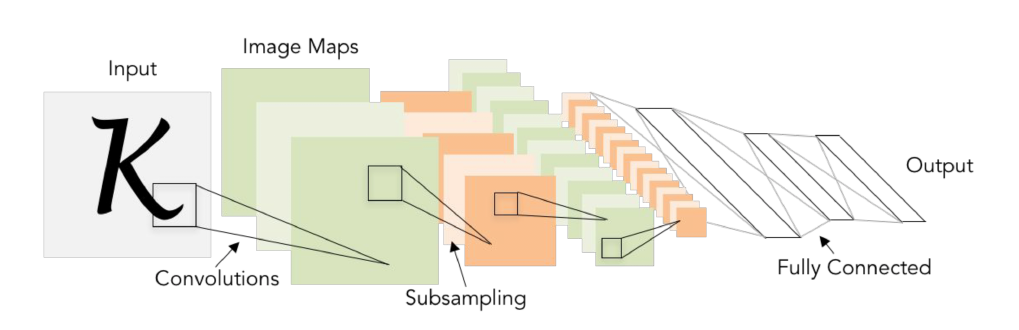

### step1:一開始一樣是打開個空白的神經網路(宣告要建立模型)。

In [20]:
model = Sequential()

### Step2 建立第一個Layer
第一個隱藏層要告訴 Keras 我們輸入手寫圖像長什麼樣子。
`padding` 設成 `same` 是 filter後會輸出和原來手寫圖形 28x28 一樣大小的矩陣,padding部份就填 0 進去，這個手法稱為zero padding。
#### 卷積神經網路(Convolutional neural network, CNN):卷積計算中的步伐(stride)和填充(padding)



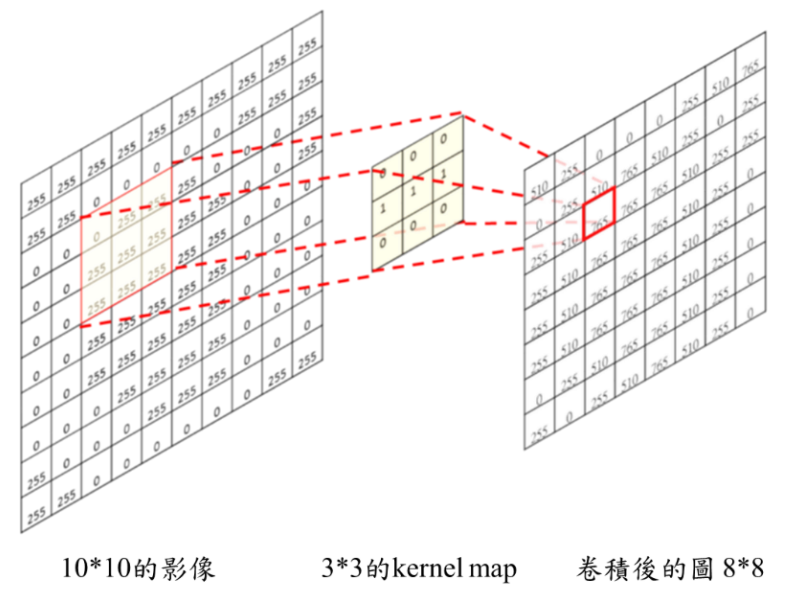

一般看到的卷積介紹，大概就像上圖，圖會因為你的kernel map(Filter)大小做完卷積後變的更小，一般卷積網路過程中，除了Input image不稱為Feature map外，中間產生的圖我們都稱之為Feature map，原因很簡單就是這些中間產生的圖都是為了「描繪出該任務所應該產生對應的特徵資料」，深度學習過程就是在學資料的特性，所以中間出來的結果都是特徵資料，在影像因為是2D，所以用Feature map來稱呼。
所以一個卷積計算基本上有幾個部份:
1. 輸入的圖: 假設大小是W × W。
2. Filter (kernel map)大小是 ks × ks
3. Stride: kernel map在移動時的步伐長度 S
4. 輸出的圖大小為 new_height × new_width
上圖的例子
1. 輸入的圖: W × W =10 × 10。
2. Filter (kernel map): ks × ks=3 × 3
3. Stride: S=1
4. 輸出的圖大小為 new_height × new_width = 8 × 8
上圖的範例產生了2個問題
1. 是不是卷積計算後，卷積後的圖是不是就一定只能變小?
2. 卷積計算是不是一次只能移動一格?
卷積計算部份除了基本的input和filter (kernel map)通常還有兩個參數可以調(strides, padding)，這邊舉tensorflow的例子:
tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)
strides和 padding這兩個參數就是在解決上面說的兩個問題。
若要卷積計算後，圖不變小,就要用zero padding
這個手法就是看你會消失多少的大小，在輸入的圖部份就給你加上0元素進去，這個手法稱為zero padding，實際作法如下圖。

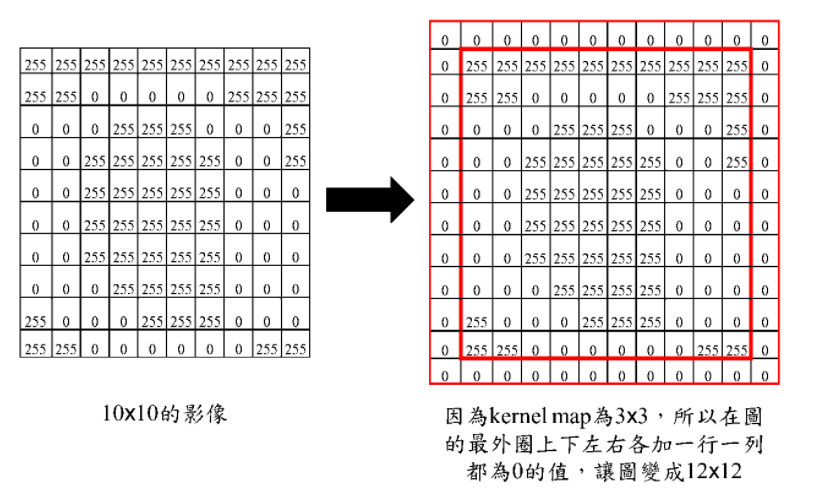

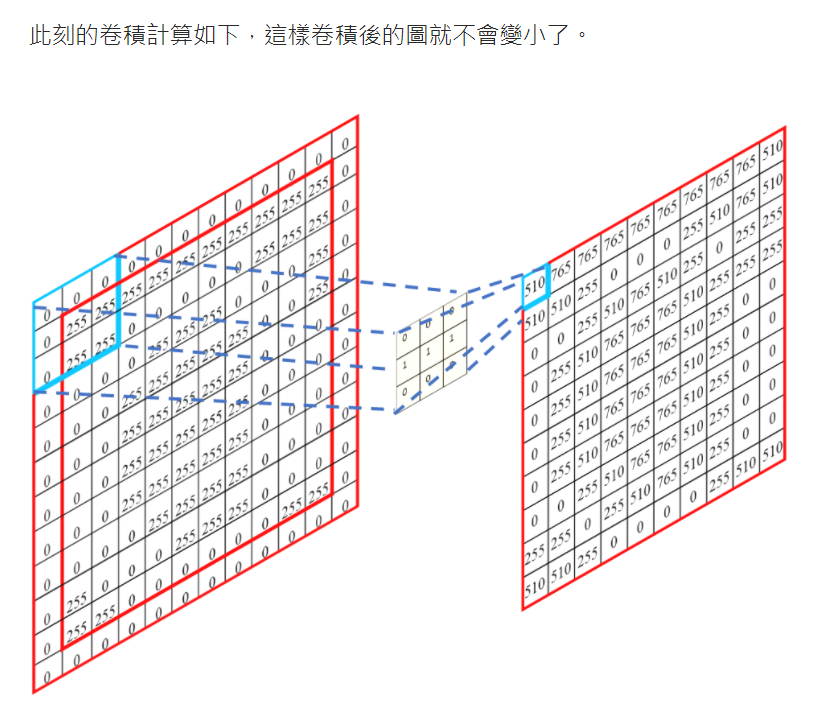

卷積計算也不是一次只能移動一格,也可以2格3格，但此時卷積後的圖就會變的更小。
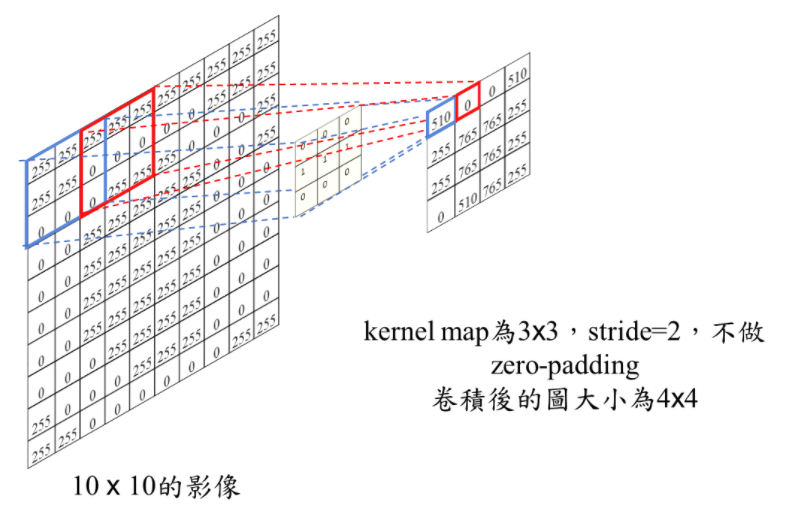

### Keras 提供的常用 Activation Function
Activation Function 除了提供非線性函數的轉換外，也是一種門檻(Threshold)的過濾，例如，sigmoid，將預測值(W * X) 轉為 [0,1] 之間，只有預測值大於0，才會傳導至下一層的神經元。Keras 提供非常多種的 Activation Function，以下只列出常用的函數，其他請參考官方文件：
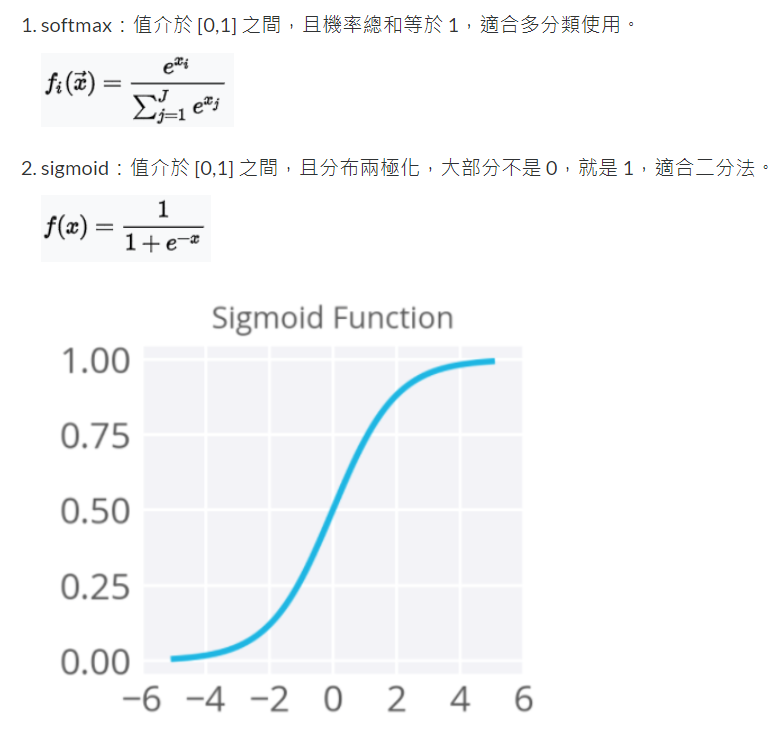


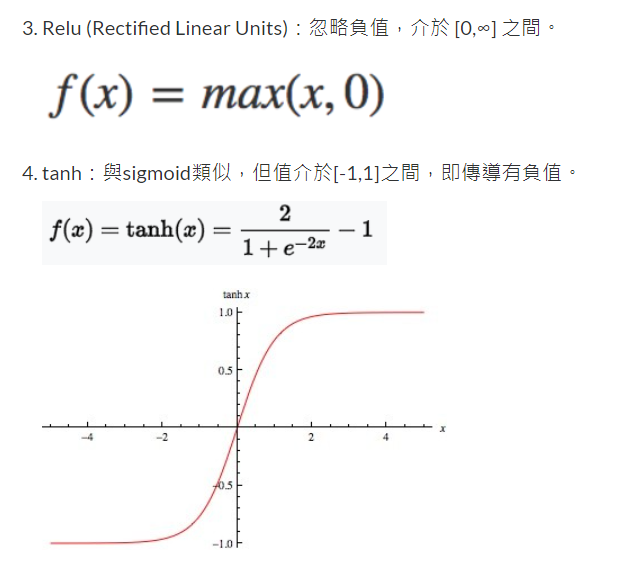

In [21]:
#輸入層:28X28X1 相片==>input_shape=(28,28,1)==>輸入有 28X28 個相素點
#Conv2D
#第一層 
#做32種Conv(filter,有32個神經元==>32種特徵擷取filter),每個 filter都是 3X3 filter,==>Conv2D(32, (3, 3)
#輸入的圖片做 zero-padding==>padding='same'
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28,28,1)))
#神經元激發function 採用 relu
model.add(Activation('relu'))

### Step3 建立要連接的 pool 層:採用Max-Pooling

In [22]:
model.add(MaxPooling2D(pool_size=(2, 2)))

### Step4 建立第二 個 Convolution層

In [23]:
#第二層 64 種Conv,3X3 filter,zero-padding
model.add(Conv2D(64, (3, 3), padding='same'))
#激發function 採用 relu
model.add(Activation('relu'))

### Step5 再接pool 層:再次採用 Max-Pooling

In [24]:
model.add(MaxPooling2D(pool_size=(2, 2)))

### Step6 建立第三 個 Convolution 層

In [25]:
#第三層 128 種Conv,3X3 filter,zero-padding
model.add(Conv2D(128, (3, 3), padding='same'))
#激發function 採用 relu
model.add(Activation('relu'))

### Step7 再接pool 層:Max-Pooling (最終回)

In [26]:
model.add(MaxPooling2D(pool_size=(2, 2)))

### Step8 建立攤平層 ==> Flatten层
用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
然後我們要送進全连接层的神經網路了。記得這是要拉平的,  Keras 會幫我們做!
這例子 攤平後有1150個資料點 

In [27]:
model.add(Flatten())


In [28]:
model.output_shape

(None, 1152)

### STEP 9 建立全连接层==> Dense layer 
就是常提到和用到的全连接层

In [29]:
# Dense(200)==>输出空间维度 200個
model.add(Dense(200))
##激發function 採用 relu
model.add(Activation('relu'))

### STEP 10  輸出層
再接一Dense layer做輸出層: 10 node 輸出

In [30]:
model.add(Dense(10))
#採用softmax 轉為機率分布
model.add(Activation('softmax'))

### 3.3 組裝模型衡量指標
我們還要透過 `compile` 才能正式把上述的CNN神經網路模型建好。==>配置训练模型的相關 衡量或調整參數如 loss function...
#### 先了解一下， Neural Network 處理流程
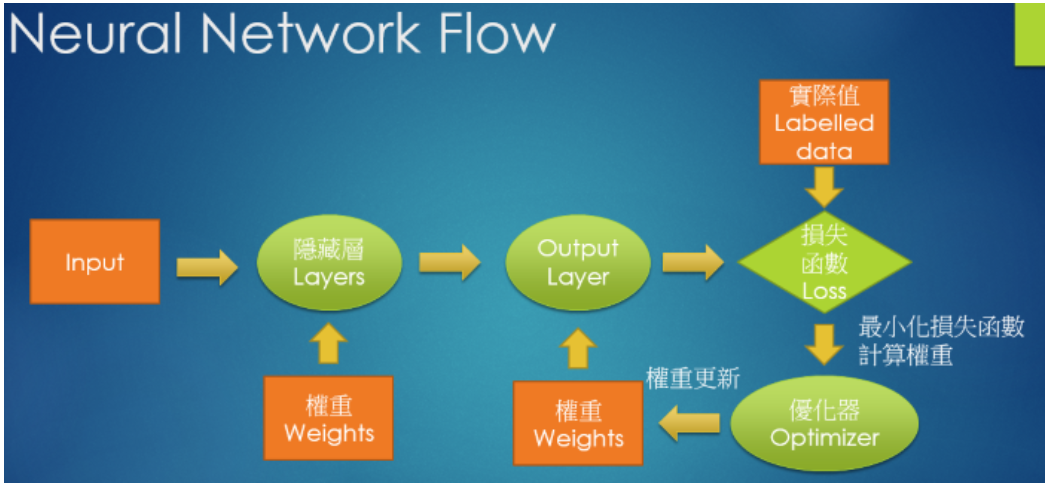


#### 在這步驟要確立模型目標及優化方法：以compile函數 選擇設定==>損失函數(loss)、優化函數(optimizer)及模型成效衡量指標(mertrics)。

### Keras 提供的常用損失函數
損失函數是計算與目標(正確值)的差距,通常是最小化
#### 1.均方誤差(mean_squared_error)：就是最小平方法(Least Square) -- 預測值與實際值的差距之平均值。還有其他變形的函數, 如 mean_absolute_error、mean_absolute_percentage_error、mean_squared_logarithmic_error。



#### 2.Hinge Error (hinge)：是一種單邊誤差，不考慮負值，適用於『支援向量機』(SVM)的最大間隔分類法(maximum-margin classification)，詳細請參考 https://en.wikipedia.org/wiki/Hinge_loss。同樣也有多種變形，squared_hinge、categorical_hinge 。
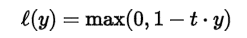


#### 3.Cross Entropy (categorical_crossentropy)：當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值，主張要用 Cross Entropy 取代 MSE，因為，在梯度下時，Cross Entropy 計算速度較快，其他變形包括 sparse_categorical_crossentropy、binary_crossentropy。
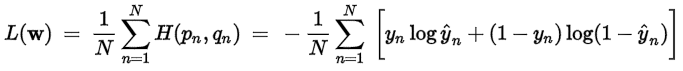


#### 4.其他還有 logcosh、kullback_leibler_divergence、poisson、cosine_proximity 等。
##### 注意! 損失函數、Activation Function 不限使用現成的函數，也可以自訂函數，尤其是損失函數，我們常需要自訂，
##### 例如目標函數為庫存成本，我們通常要最小化，但是，如果我們應用在銷售系統上，要極大化銷貨利益，假設庫存短缺造成無法接單，所減少的收益(L1)是兩倍於庫存的儲藏成本(L2)，損失函數就應該訂為 L1 * 2 + L2。
##### 另外，我們的目標可能是『最大化』收益，而非最小化損失，我們就必須對變數作一些轉換，使函數變為『最小化"負"收益』，因為，Keras優化都是『最小化』(Minimize)求解，沒有最大化(Maximize)。

### Keras 提供的優化函數(Optimizer)
#### 1.隨機梯度下降法(Stochastic Gradient Descent, SGD)：就是利用偏微分，逐步按著下降的方向，尋找最佳解。它含以下參數：
Learning Rate (lr)：逼近最佳解的學習速率，速率訂的太小，計算最佳解的時間花費較長，訂的太大，可能會在最佳解兩旁擺盪，找不到最佳解。
momentum：更新的動能，一開始學習速率可以大一點，接近最佳解時，學習速率步幅就要小一點，一般訂為0.5，不要那麼大時，可改為 0.9。
decay：每次更新後，學習速率隨之衰減的比率。
nesterov：是否使用 Nesterov momentum，請參考 http://blog.csdn.net/luo123n/article/details/48239963 。
#### 2.Adam：一般而言，比SGD模型訓練成本較低，請參考『Adam - A Method for Stochastic Optimization』，包含相關參數建議值，含以下參數：
lr：逼近最佳解的學習速率，預設值為0.001。
beta_1：一階矩估計的指數衰減因子，預設值為0.9。
beta_2：二階矩估計的指數衰減因子，預設值為0.999。
epsilon：為一大於但接近 0 的數，放在分母，避免產生除以 0 的錯誤，預設值為1e-08。
decay：每次更新後，學習速率隨之衰減的比率。
#### 3.其他優化函數請參考官方文件。
https://keras.io/api/optimizers/

### 评估标准 Metrics
评价函数用于评估当前训练模型的性能。評價函式的選擇直接決定了模型的準確度
#### Keras 定義了6種不同的评估标准，最常用的就是 accuracy，舉例：

　　accuracy真實標簽和模型預測均為標量，如果真實標簽序列為[1, 1, 3, 0, 2, 5]，預測序列為[1, 2, 3, 1, 2, 5]，此時可以看到命中了四個，則[accuracy] = 4/6 = 0.6667，
#### binary_accuracy，這種評價函式適用于二分類問題的處理，舉例：
樣本集合應該有真實標簽序列，如[0, 1, 1, 0]，模型預測為概率序列，如[0.3, 0.7, 0.6, 0.9]，但是現在我們只有概率序列該怎么和標簽序列比較呢，該評價函式有一個threshold引數，引數的默認值為0.5，預測序列中概率 > threshold的設為1，< = threshold的設為0，所以模型預測會由[0.3, 0.7, 0.6, 0.9]轉換為[0, 1, 1, 1]
#### categorical_accuracy和 sparse_categorical_accuracy
適用於多分類問題或者多標簽的任務
#### categorical_accuracy
首先真實值和預測值都是一個one-hot向量，這個評價函式的策略是比較兩個向量中最大元素的下標index值是否一致
##### 注意，這里只比較一個值，即最大的那個值的index，這對于多分類單標簽任務的是合適的，但并不適用于多標簽任務，舉個例子來說就好比真實值為[0, 0, 1, 0]而預測值為[0.2, 0.1, 0.9, 0.5]則視為預測準確，
#### sparse_categorical_accuracy
真實值本身已經是下標index，而預測值仍然是個向量，比較真實值的下標值所對應的預測序列中的值是否為整個序列中最大的，如果是，則視為預測精準，比如真實值為2（注意下標從0開始），預測序列為[0.1, 0.38, 0.79, 0.5]，評價結果視為預測準確，
#### top_k_categorical_accuracy
它相當于在categorical_accuracy的基礎上加上top_k之后自然考慮的不再是單一序列下標號的比較，categorical_accuracy要求樣本在真值類別上的預測分數是在所有類別上預測分數的最大值，才算預測對，而top_k_categorical_accuracy只要求樣本在真值類別上的預測分數排在其在所有類別上的預測分數的前k名就行，
#### 例子：比如有5個樣本，其真實值為[[0, 1, 0], [0, 0, 1], [0, 1, 0], [0, 1, 0], [1, 0, 0]]，預測序列為[[0.8, 0.2, 0.1], [0.3, 0.6, 0.1], [0.5, 0.4, 0.1], [0.3, 0.6, 0.1], [0.9, 0, 0.1]]，
根據前面知識我們可以計算得到其categorical_accuracy=40%，但是如果你選擇的評價函式是top_k_categorical_accuracy答案就完全不一樣了，可以這么說，top_k有著更寬松的約束，因為相當于允許最大值只需要排進前k就算預測對了，當然這也就意味著預測準確與否跟k的取值息息相關，比如剛才這個例子，如果k取值 > = 3，其top_k_categorical_accuracy是100%，是因為每個向量里總共就3個類別，最大值肯定位于前3之內，那就是百分之百準確了沒有意義，所以設定k值小于向量元素長度3才有意義，比如如果我們設定k = 2，那么top_k_ accuracy=75%，具體計算方法為：1）首先，將真值序列轉為非onehot的形式，即[1, 2, 1, 1, 0]（就是取出最大值的下標index組成新的向量）2）計算預測值的top_k的label，比如k=2時，預測值的序列可以轉化為 = [[0, 1], [0, 1], [0, 1], [0, 1], [0, 2]]（即找到預測序列中前兩個比較大的值所對應的下標Index）3）根據每個樣本的真實標簽是否在預測標簽的top_k內來統計準確率，上述5個樣本為例，1在[0, 1]內，2不在[0, 1]內，1在[0, 1]內，1在[0, 1]內，0在[0, 2]內，5個樣本總共預測對了4個，因此k=2時top_k_categorical_accuracy=80%，注意在使用的程序中Keras默認的k值取為5，所以如果在呼叫時如果使用默認值，需要確保分類個數>5才行否則將出現命中率100%的情況，
#### sparse_top_k_categorical_accuracy
與top_k_categorical_accurac也是一樣的思路，只不過sparse_top_k真值不是onehot的形式，（類比剛才多分類的兩個評分函式的區別來理解會有所幫助）

　　假設給定4個樣本，其真值序列為[2, 1, 2, 2]，預測序列為[[0.2, 0.5, 0.15], [0.5, 0.3, 0.1], [0.3, 0.7, 0.2], [0.9, 0.05, 0.4]]，計算sparse_top_k_categorical_accuracy的命中率應該按照如下方法：首先假設選擇k=2，則先將預測序列轉化成[[0, 1], [0, 1], [0, 1], [0, 2]]，我們可以通過剛才的方法來逐個查看，2不在[0, 1]中，1在[0, 1]中，2不在[0, 1]中，2在[0, 2]中，所以4個樣本命中了2個，命中率為50%，

　　其實可以發現當兩種top_k方法中當你把k設定為1時，top_k_categorical_accuracy和sparse_top_k_categorical_accuracy方法會由于k值太小而退化為前兩種categorical_accuracy以及sparse_categorical_accuracy方法，
#### 總結使用場景
#### 1) 如果真實值標簽和預測值都是具體的index值（如真值序列 = [1, 1, 1], y_pred=[0, 1, 1]）時，直接使用accuracy評價函式就可以滿足大部分情況，（即非常簡單的應用場景，資料集當中有明確的分類資訊label）
#### 2) 如果真實值標簽是具體的index值，而預測值是向量形式，且問題為多分類問題（如真實值= [1, 1, 1], 預測序列=[[0.2, 0.3, 0.5], [0.45, 0.2, 0.35], [0, 0.24, 0.78]]）時，用sparse_categorical_accuracy評價函式可以解決問題，
#### 3）如果真實值標簽是one-hot形式，而預測值是向量形式（如真實值 = [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 預測值= [[0.52, 0.33, 0.15], [0.9, 0.1, 0], [0, 0.4, 0.6]]）時，用categorical_accuracy評價函式就可以，


#### compile
用于配置組裝训练模型的相關 參數 如下說明

##### compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
参数

optimizer: 字符串（优化器名）或者优化器实例。 详见 optimizers。
loss: 字符串（損失函数名）或目标函数。 详见 losses。 如果模型具有多个输出，则可以通过传递损失函数的字典或列表，在每个输出上使用不同的损失。 模型将最小化的损失值将是所有单个损失的总和。
metrics: 在训练和测试期间的模型评估标准。 通常你会使用 metrics = ['accuracy']。 要为多输出模型的不同输出指定不同的评估标准， 还可以传递一个字典，如 metrics = {'output_a'：'accuracy'}。
loss_weights: 可选的指定标量系数（Python 浮点数）的列表或字典， 用以衡量损失函数对不同的模型输出的贡献。 模型将最小化的误差值是由 loss_weights 系数加权的加权总和误差。 如果是列表，那么它应该是与模型输出相对应的 1:1 映射。 如果是张量，那么应该把输出的名称（字符串）映到标量系数。
sample_weight_mode: 如果你需要执行按时间步采样权重（2D 权重），请将其设置为 temporal。 默认为 None，为采样权重（1D）。 如果模型有多个输出，则可以通过传递 mode 的字典或列表，以在每个输出上使用不同的 sample_weight_mode。
weighted_metrics: 在训练和测试期间，由 sample_weight 或 class_weight 评估和加权的度量标准列表。
target_tensors: 默认情况下，Keras 将为模型的目标创建一个占位符，在训练过程中将使用目标数据。 相反，如果你想使用自己的目标张量（反过来说，Keras 在训练期间不会载入这些目标张量的外部 Numpy 数据）， 您可以通过 target_tensors 参数指定它们。 它可以是单个张量（单输出模型），张量列表，或一个映射输出名称到目标张量的字典。


In [31]:
#model.compile(loss="categorical_crossentropy",
#              optimizer=Adadelta(),
#              metrics=['accuracy'])

In [32]:
model.compile(loss='mse', optimizer=SGD(lr=0.05), metrics=['accuracy'])

### 3.4 檢視我們的CNN神經網路模型

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

## 4. 訓練CNN模型
model.fit()方法用于执行模型训练
### model.fit( 训练集的输入特征，

                 训练集的标签，  

                 batch_size,  #每一个batch的大小

                 epochs,   #迭代次数

                 validation_data = (测试集的输入特征，测试集的标签），

                 validation_split = 从测试集中划分多少比例给训练集，

                 validation_freq = 测试的epoch间隔数）

#### batch_size ==>設 miniBatch 每個iteration抓幾筆訓練資料做計算
#### epochs  ==>總共要用全部的訓練樣本重複跑幾回合

In [34]:
model.fit(x_train, y_train, batch_size=100, epochs=12)

Epoch 1/12
600/600 [==============================] - 23s 38ms/step - loss: 0.1796 - accuracy: 0.1022
Epoch 2/12
600/600 [==============================] - 23s 38ms/step - loss: 0.1649 - accuracy: 0.1573
Epoch 3/12
600/600 [==============================] - 23s 38ms/step - loss: 0.0979 - accuracy: 0.4458
Epoch 4/12
600/600 [==============================] - 23s 38ms/step - loss: 0.0265 - accuracy: 0.8272
Epoch 5/12
600/600 [==============================] - 23s 38ms/step - loss: 0.0219 - accuracy: 0.8527
Epoch 6/12
600/600 [==============================] - 23s 38ms/step - loss: 0.0200 - accuracy: 0.8626
Epoch 7/12
600/600 [==============================] - 23s 38ms/step - loss: 0.0176 - accuracy: 0.8765
Epoch 8/12
600/600 [==============================] - 23s 38ms/step - loss: 0.0060 - accuracy: 0.9607
Epoch 9/12
600/600 [==============================] - 23s 38ms/step - loss: 0.0048 - accuracy: 0.9693
Epoch 10/12
600/600 [==============================] - 23s 39ms/step - loss: 0.004

## 5. 驗證評估(Evaluation)模型：訓練完後，計算CNN模型成效

### model.evaluate
##### 用于执行模型測試驗證
Keras中model.evaluate（）返回的是 损失值和你选定的指标值（例如，精度accuracy）

In [35]:
score = model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0039 - accuracy: 0.9755


In [36]:
print('測試資料的 loss:', score[0])
print('測試資料正確率:', score[1])

測試資料的 loss: 0.0038533874321728945
測試資料正確率: 0.9754999876022339


## 6. 儲存模型結果

結果看來還不差, 所以我們把結果存起來。

In [37]:
model_json = model.to_json()
open('handwriting_model_cnn8.json', 'w').write(model_json)
model.save_weights('handwriting_weights_cnn8.h5')

## 7. 模型上線進行預測(Prediction)：經過反覆訓練，有了可信模型後，就可將系統上線使用了。

欣賞一下成果
我們用另一個方式: 每次選 5 個顯示, 看是不是有正確辨識。
### 丟入test集資料做驗證

In [49]:
#predict = model.predict_classes(x_test) # tf<2.6
predict = model.predict(x_test)
#使用 predict 方法，它会返回每个输入样本的预测概率。然后，你可以通过取最大概率来获取预测的类别标签
predicted_labels = np.argmax(predict, axis=1)
print(predicted_labels)

313/313 [==============================] - 1s 5ms/step
[7 2 1 ... 4 5 6]


### 使用隨機資料看 test資料集的預測 結果(抽取驗證)

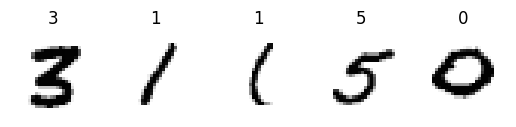

In [66]:
pick=np.random.randint(1,9999,5)

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[pick[i]].reshape(28,28), cmap='Greys')
    plt.title(predicted_labels[pick[i]])
    plt.axis("off")

## 8. 結論

我們到此, 基本上是「亂做」的神經網路。有些同學在不斷試驗的過程中, 可能會發現有時會出現很糟糕的結果。因此, 接下來要想怎麼樣用些手法, 能讓學習效果比較穩定, 而且有可能可以增加學習效率。

In [67]:
def plot_images_labels(images,labels,prediction,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(20,14)
    if num>25:
        num=15
    for i in range(0,num):
        ax=plt.subplot(5,5,1+i)
        ax.imshow(np.reshape(images[idx],(28,28)), cmap='binary')
        title="label=" +str(labels[idx])
        if len(prediction)>0:
            title+=",predict="+str(prediction[idx])
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx=idx+1
    plt.show()

313/313 [==============================] - 1s 5ms/step


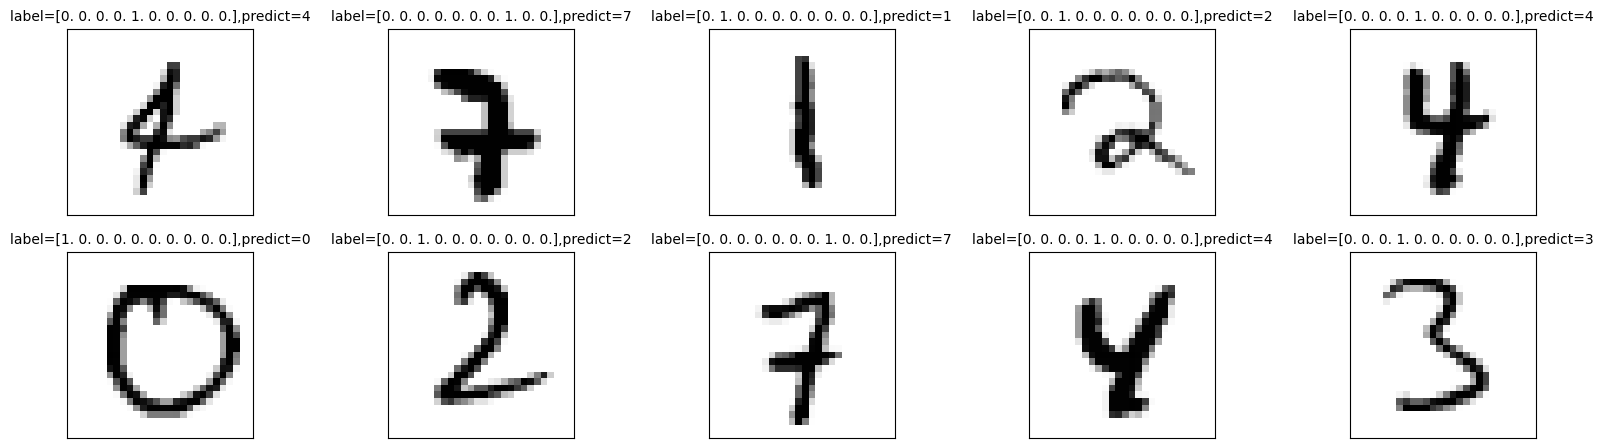

In [69]:
#prediction=model.predict_classes(x_test)
prediction=model.predict(x_test)
predicted_labels = np.argmax(prediction, axis=1)
plot_images_labels(x_test,y_test,predicted_labels,idx=300)

### python 语言的数字图片处理包，比如PIL,Pillow, opencv, scikit-image等。
### PIL和Pillow只提供最基础的数字图像处理，功能有限；opencv实际上是一个c++库，只是提供了python接口。
### scikit-image是基于scipy的一款图像处理包，它将图片作为numpy数组进行处理，
### Image读出来的是PIL的类型，而skimage.io读出来的数据是numpy格式的
### 输出可以看出Img读图片的大小是图片的(width, height)；而skimage的是(height,width, channel)

In [73]:
#conda  install scikit-image imageio numpy scipy
!pip install --upgrade scikit-image imageio numpy scipy


     ---------------------------------------- 23.9/23.9 MB 8.3 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 7.7 MB/s eta 0:00:00
  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
     ---------------------------------------- 42.5/42.5 MB 6.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


ERROR: Could not install packages due to an OSError: [WinError 5] \u5b58\u53d6\u88ab\u62d2\u3002: 'D:\\Users\\hgtma\\anaconda3\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [142]:
# 使用小畫家，寫0~9，實際測試看看
from skimage import io
#from skimage.transform import resize
import numpy as np
import plotly.express as px
from skimage import color
uploaded_file = './myDigits/3.png'
image1 = io.imread(uploaded_file)
image1
#0黑,255白

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [143]:
image1.shape
#image1[:,:,0]


(28, 28, 3)

In [144]:
px.imshow(image1)

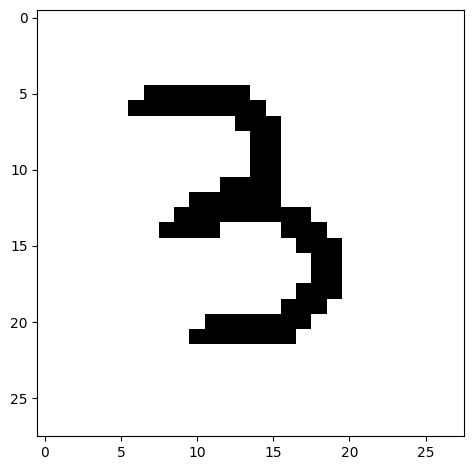

In [145]:
imgGray = color.rgb2gray(image1)

io.imshow(imgGray)

In [146]:
imgGray.shape

(28, 28)

In [147]:
imgGray
#0黑,1白

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 1

In [148]:
#28X28=784變成 1列
X1 = imgGray.reshape(1,28, 28, 1)
X1.shape


(1, 28, 28, 1)

In [149]:
X1[:,0]

array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]])

In [150]:
#顛倒黑白==>0白,1黑
X1 = np.abs(1-X1)
predictions = model.predict(X1)
predicted_label = np.argmax(predictions, axis=1)
print(predicted_label)

1/1 [==============================] - 0s 15ms/step
[3]
